In [44]:
# first implement RNN
# apply many times and check that things don't blow up or vanish
# RMS norm etc can help
from torch import nn
import torch
from matplotlib import pyplot as plt
import numpy as np 

class Cell(nn.Module):
    def __init__(self, d_model, d_ff) -> None:
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)
        self.act = nn.SiLU()
        self.reset()
        
    def forward(self, x):
        y = self.act(self.linear1(x))
        y = self.dropout(x)
        y = self.linear2(x)
        return self.ln2(x + self.ln1(y))
    
    def reset(self):
        for name, p in self.named_parameters():
            if "weight" in name and "linear" in name:
                nn.init.normal_(p, 0, 2) / p.shape[0] ** 0.5 * 10
            elif "weight" in name:
                nn.init.ones_(p)
            elif "bias" in name:
                nn.init.zeros_(p)

In [77]:
d_model = 128
steps = 100
batch = 1

model = Cell(d_model, d_model)
X = torch.randn(batch, d_model, requires_grad=True)
y = [X]
jacobians = []
for i in range(steps):
    y.append(model(y[-1]))
    jacobians.append(torch.autograd.functional.jacobian(model, y[-2]))
y = torch.stack(y, dim=1).cpu().detach().numpy()
jacobians = torch.stack(jacobians, dim=1).cpu().detach().numpy()

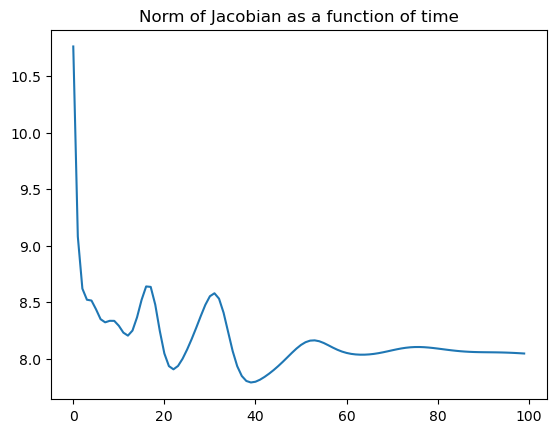

In [85]:
j = np.linalg.norm(jacobians.squeeze(), axis=(1,2))
plt.plot(j)
plt.title("Norm of Jacobian as a function of time")
plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 128, 1)

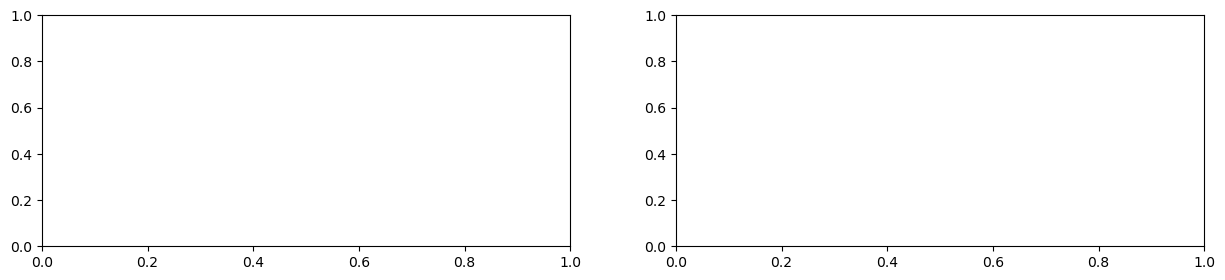

In [86]:
j = jacobians
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].plot(j.std(0).mean(-1), label="mean across feat of std(batch)")
# axes[0].plot(y.reshape(-1, d_model).std(0), label="standard deviation across features and batch")
axes[0].set_xlabel("time step")
axes[0].set_ylabel("standard deviation")
axes[0].legend()
plt.imshow(j.std(0).T)
plt.xlabel("time step")
plt.ylabel("output feature")
plt.colorbar()
plt.title(r"Standard deviation of Jacobian $ \cdot 1$")

In [53]:
y.reshape()

array([ 0.40920675,  0.8652258 ,  0.34203154, ..., -0.32122016,
        0.12963603,  1.5333942 ], dtype=float32)

Text(0.5, 1.0, 'Standard deviation of output features')

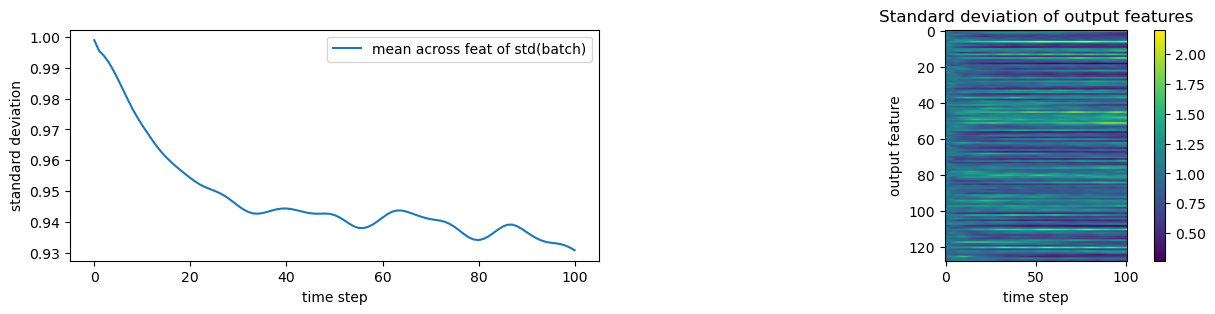

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].plot(y.std(0).mean(-1), label="mean across feat of std(batch)")
# axes[0].plot(y.reshape(-1, d_model).std(0), label="standard deviation across features and batch")
axes[0].set_xlabel("time step")
axes[0].set_ylabel("standard deviation")
axes[0].legend()
plt.imshow(y.std(0).T)
plt.xlabel("time step")
plt.ylabel("output feature")
plt.colorbar()
plt.title("Standard deviation of output features")